# Bibliotheken/Einlesen

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [307]:
df_test1 = pd.read_parquet("../Daten/energy_test1.parquet")
df_test2 = pd.read_parquet("../Daten/energy_test2.parquet")
df_train = pd.read_parquet("../Daten/energy_train.parquet")
df_forecasts = pd.read_parquet("../Daten/forecasts.parquet")

# Beobachtung der Daten

In [308]:
df_test1

,dtm,ref_datetime,Solar_capacity_mwp
0,2023-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
1,2023-01-01 01:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
2,2023-01-01 02:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
3,2023-01-01 03:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
4,2023-01-01 04:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
...,...,...,...
7268,2023-10-30 20:00:00+00:00,2023-10-29 18:00:00+00:00,2452.979156
7269,2023-10-30 21:00:00+00:00,2023-10-29 18:00:00+00:00,2452.979156
7270,2023-10-30 22:00:00+00:00,2023-10-29 18:00:00+00:00,2452.979156
7271,2023-10-30 23:00:00+00:00,2023-10-29 18:00:00+00:00,2452.950587


In [309]:
df_test1.columns

Index(['dtm', 'ref_datetime', 'Solar_capacity_mwp'], dtype='object')

In [310]:
df_test1.dtypes

dtm                   datetime64[ns, UTC]
ref_datetime          datetime64[ns, UTC]
Solar_capacity_mwp                float64
dtype: object

In [311]:
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7245 entries, 0 to 7272
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   dtm                 7245 non-null   datetime64[ns, UTC]
 1   ref_datetime        7245 non-null   datetime64[ns, UTC]
 2   Solar_capacity_mwp  7245 non-null   float64            
dtypes: datetime64[ns, UTC](2), float64(1)
memory usage: 226.4 KB


In [312]:
df_test2

,dtm,ref_datetime,Solar_capacity_mwp
0,2023-10-31 01:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
1,2023-10-31 02:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
2,2023-10-31 03:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
3,2023-10-31 04:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
4,2023-10-31 05:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019
...,...,...,...
9330,2024-11-22 19:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562944
9331,2024-11-22 20:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562903
9332,2024-11-22 21:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562872
9333,2024-11-22 22:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562858


In [274]:
df_test2.columns

Index(['dtm', 'ref_datetime', 'Solar_capacity_mwp'], dtype='object')

In [275]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7465 entries, 0 to 9334
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   dtm                 7465 non-null   datetime64[ns, UTC]
 1   ref_datetime        7465 non-null   datetime64[ns, UTC]
 2   Solar_capacity_mwp  7465 non-null   float64            
dtypes: datetime64[ns, UTC](2), float64(1)
memory usage: 233.3 KB


In [276]:
df_train

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh
0,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0
1,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0
2,2020-09-21 02:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0
3,2020-09-21 03:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0
4,2020-09-21 04:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0
...,...,...,...,...
19963,2022-12-31 19:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0
19964,2022-12-31 20:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0
19965,2022-12-31 21:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0
19966,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0


In [277]:
df_train.columns

Index(['dtm', 'ref_datetime', 'Solar_capacity_mwp', 'Solar_MWh'], dtype='object')

In [278]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19968 entries, 0 to 19967
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   dtm                 19968 non-null  datetime64[ns, UTC]
 1   ref_datetime        19968 non-null  datetime64[ns, UTC]
 2   Solar_capacity_mwp  19968 non-null  float64            
 3   Solar_MWh           19964 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(2)
memory usage: 624.1 KB


In [279]:
# TODO Zeilen anpassen (durchschnitt, vorheriger Wert) oder löschen
df_train[df_train.Solar_MWh.isna()]

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh
19255,2022-12-02 07:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659752,NaN
19256,2022-12-02 08:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN
19257,2022-12-02 09:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN
19258,2022-12-02 10:00:00+00:00,2022-12-01 06:00:00+00:00,2205.659763,NaN


In [280]:
len(df_train[df_train.Solar_MWh.isna()])

4

In [281]:
df_forecasts

,ref_datetime,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model
0,2020-09-20 00:00:00+00:00,20,-0.010547,0.366211,13.823755,DWD ICON
1,2020-09-20 00:00:00+00:00,21,0.001263,0.471512,13.427564,DWD ICON
2,2020-09-20 00:00:00+00:00,22,0.001532,0.398212,13.093005,DWD ICON
3,2020-09-20 00:00:00+00:00,23,-0.001624,0.292247,12.667871,DWD ICON
4,2020-09-20 00:00:00+00:00,24,-0.008356,0.327759,12.216522,DWD ICON
...,...,...,...,...,...,...
606792,2024-11-24 06:00:00+00:00,68,1.820000,1.000000,2.050000,NCEP GFS
606793,2024-11-24 06:00:00+00:00,69,0.930000,1.000000,2.700000,NCEP GFS
606794,2024-11-24 06:00:00+00:00,70,0.050000,1.000000,3.130000,NCEP GFS
606795,2024-11-24 06:00:00+00:00,71,0.000000,1.000000,3.560000,NCEP GFS


In [282]:
df_forecasts.columns

Index(['ref_datetime', 'valid_time', 'SolarDownwardRadiation', 'CloudCover',
       'Temperature', 'Weather Model'],
      dtype='object')

In [283]:
df_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606797 entries, 0 to 606796
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   ref_datetime            606797 non-null  datetime64[ns, UTC]
 1   valid_time              606797 non-null  int64              
 2   SolarDownwardRadiation  605571 non-null  float64            
 3   CloudCover              606422 non-null  float64            
 4   Temperature             606494 non-null  float64            
 5   Weather Model           606797 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(1)
memory usage: 27.8+ MB


In [284]:
df_forecasts[df_forecasts.SolarDownwardRadiation.isna()]

,ref_datetime,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model
4770,2020-10-13 06:00:00+00:00,20,NaN,NaN,NaN,DWD ICON
4771,2020-10-13 06:00:00+00:00,21,NaN,NaN,NaN,DWD ICON
4772,2020-10-13 06:00:00+00:00,22,NaN,NaN,NaN,DWD ICON
4773,2020-10-13 06:00:00+00:00,23,NaN,NaN,NaN,DWD ICON
4774,2020-10-13 06:00:00+00:00,24,NaN,NaN,NaN,DWD ICON
...,...,...,...,...,...,...
319956,2021-03-26 18:00:00+00:00,68,NaN,0.0,16.884634,NCEP GFS
319957,2021-03-26 18:00:00+00:00,69,NaN,0.0,16.942698,NCEP GFS
319958,2021-03-26 18:00:00+00:00,70,NaN,0.0,16.250010,NCEP GFS
319959,2021-03-26 18:00:00+00:00,71,NaN,0.0,15.012726,NCEP GFS


# Umgang mit NaN-Werten

__Umgang mit NaN-Werten in df_train__
- Betroffene Zeilen 4 von 19968 (ca.0,02%)
- Mein Ansatz: Zeilen, wo bei `Solar_MWh` NaN auftaucht, löschen

In [285]:
df_train = df_train.dropna(subset=["Solar_MWh"])
df_test1 = df_test1.dropna()
df_test2 = df_test2.dropna()

**Umgang mit NaN-Werten in df_forecasts**
- Betroffene Zeilen: max. 1226 von 606797 (ca. 0,2%)
- Mein Ansatz: Daten behalten und Auffüllen

In [267]:
# Spalte SolarDownwardRadiation
df_forecasts["SolarDownwardRadiation"] = df_forecasts["SolarDownwardRadiation"].interpolate(method="linear")

# Spalte CloudCover
df_forecasts["CloudCover"] = df_forecasts["CloudCover"].fillna(df_forecasts["CloudCover"].median())

# Spalte Temperature
df_forecasts["Temperature"] = df_forecasts["Temperature"].interpolate(method="linear")

C:\Users\QMoWo\AppData\Local\Temp\ipykernel_24932\1009453878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecasts["SolarDownwardRadiation"] = df_forecasts["SolarDownwardRadiation"].interpolate(method="linear")
C:\Users\QMoWo\AppData\Local\Temp\ipykernel_24932\1009453878.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecasts["CloudCover"] = df_forecasts["CloudCover"].fillna(df_forecasts["CloudCover"].median())
C:\Users\QMoWo\AppData\Local\Temp\ipykernel_24932\1009453878.py:8: SettingWit

In [286]:
df_forecasts = df_forecasts.dropna()

In [287]:
df_forecasts

,ref_datetime,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model
0,2020-09-20 00:00:00+00:00,20,-0.010547,0.366211,13.823755,DWD ICON
1,2020-09-20 00:00:00+00:00,21,0.001263,0.471512,13.427564,DWD ICON
2,2020-09-20 00:00:00+00:00,22,0.001532,0.398212,13.093005,DWD ICON
3,2020-09-20 00:00:00+00:00,23,-0.001624,0.292247,12.667871,DWD ICON
4,2020-09-20 00:00:00+00:00,24,-0.008356,0.327759,12.216522,DWD ICON
...,...,...,...,...,...,...
606792,2024-11-24 06:00:00+00:00,68,1.820000,1.000000,2.050000,NCEP GFS
606793,2024-11-24 06:00:00+00:00,69,0.930000,1.000000,2.700000,NCEP GFS
606794,2024-11-24 06:00:00+00:00,70,0.050000,1.000000,3.130000,NCEP GFS
606795,2024-11-24 06:00:00+00:00,71,0.000000,1.000000,3.560000,NCEP GFS


**Validierung nach der Bereinigung**

In [288]:
print("NaN-Werte in df_train:", df_train.isna().sum())
print("NaN-Werte in df_forecasts:", df_forecasts.isna().sum())
print("NaN-Werte in df_train:", df_test1.isna().sum())
print("NaN-Werte in df_train:", df_test2.isna().sum())

NaN-Werte in df_train: dtm                   0
ref_datetime          0
Solar_capacity_mwp    0
Solar_MWh             0
dtype: int64
NaN-Werte in df_forecasts: ref_datetime              0
valid_time                0
SolarDownwardRadiation    0
CloudCover                0
Temperature               0
Weather Model             0
dtype: int64
NaN-Werte in df_train: dtm                   0
ref_datetime          0
Solar_capacity_mwp    0
dtype: int64
NaN-Werte in df_train: dtm                   0
ref_datetime          0
Solar_capacity_mwp    0
dtype: int64


# Umgang mit Negativen Werten `SolarDownwardRadiation` (Optional)

#### Negative SolarDownwardRadiation anpassen

In [117]:
df_forecasts["SolarDownwardRadiation"] = df_forecasts["SolarDownwardRadiation"].clip(lower=0)

C:\Users\QMoWo\AppData\Local\Temp\ipykernel_24932\2420283557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecasts["SolarDownwardRadiation"] = df_forecasts["SolarDownwardRadiation"].clip(lower=0)


# Aufgabe 1 Untersuchung der Energiedaten

In [289]:
# 1. Wie viele Datenpunkte, die vorhergesagt werden sollen, gibt es in den Trainings- bzw. Testdaten?
train_points = len(df_train)

# Anzahl der Datenpunkte in den beiden Testsets
test1_points = len(df_test1)
test2_points = len(df_test2)

print(f"Trainingsdatenpunkte: {train_points}")
print(f"Testdatenpunkte - Test1: {test1_points}, Test2: {test2_points}")

Trainingsdatenpunkte: 19964
Testdatenpunkte - Test1: 7245, Test2: 7465


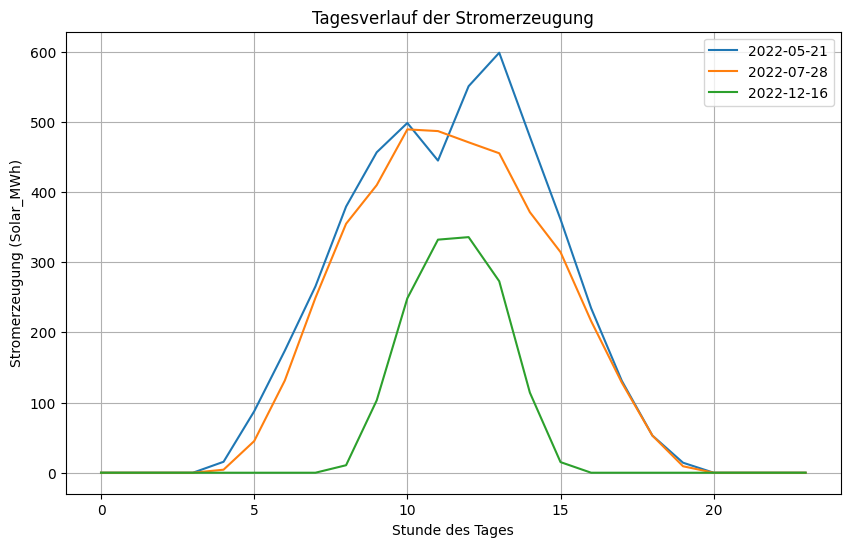

In [219]:
# 2. Tagesverlauf visualisieren
# (Zufälige)Geburtstage auswählen, bzw. Frühlings-, Sommer- und Winterzeit
birthdates = ["2022-05-21", "2022-07-28", "2022-12-16"]
birthdates = pd.to_datetime(birthdates) # Strings in datetime umwandeln

df_train["date"] = pd.to_datetime(df_train["dtm"]).dt.date  # Extrahiere das Datum

# Filter für die ausgewählten Tage
filtered_data = df_train[df_train["date"].isin(birthdates.date)]

# Plot
plt.figure(figsize=(10, 6))
for date in birthdates:
    daily_data = filtered_data[filtered_data["date"] == date.date()]
    plt.plot(
        pd.to_datetime(daily_data["dtm"]).dt.hour,
        daily_data["Solar_MWh"],
        label=str(date.date())
    )
plt.xlabel("Stunde des Tages")
plt.ylabel("Stromerzeugung (Solar_MWh)")
plt.title("Tagesverlauf der Stromerzeugung")
plt.legend()
plt.grid()
plt.show()

2022-05-21  Frühling <br>
2022-07-28 -> Sommer <br>
2022-12-16 -> Winter <br>
Man erkennt deutlich, dass logischerweise Nachts kein Strom produziert wird und der Tag der wichtige Teil für die Stromerzeugung. Auch erkennbar ist, dass der Winter weniger Strom produziert, was sehr stark an der Wolkenbedeckung liegen kann und die Tageszeit kürzer anhält als Frühling und Sommer.
Einen kleinen Ausreißer erkennt man beim Frühling, was bei ca. 10-12Uhr kurz wenig Strom produziert. Das könnte an einem Regenschauer liegen oder anderen technischen Fehlern

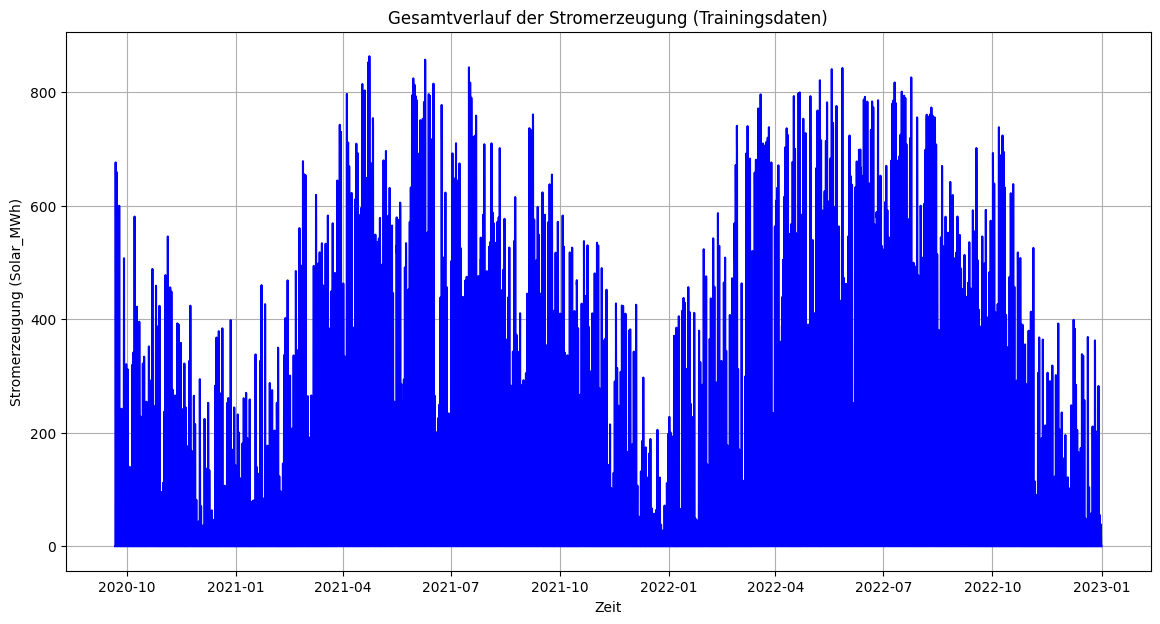

In [290]:
# 3. Gesamtverlauf visualisieren
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(df_train["dtm"]), df_train["Solar_MWh"], color="blue")
plt.xlabel("Zeit")
plt.ylabel("Stromerzeugung (Solar_MWh)")
plt.title("Gesamtverlauf der Stromerzeugung (Trainingsdaten)")
plt.grid()
plt.show()

Im Sommer steigt die Stromerzeugung, da es länger hell bleibt und wenig Wolkenbedeckung hat. <br>
Im Winter sinkt die Stromerzeugung, da es schneller dunkel wird und weniger Sonnenschein tagsüber hat.

# Aufgabe 2 Merge und Untersuchung von Zusammenhänge

## Merge mit Trainingsdaten

In [299]:
# Transformiere "ref_datetime" und "dtm" zu datetime
df_train["dtm"] = pd.to_datetime(df_train["dtm"])
df_test1["dtm"] = pd.to_datetime(df_test1["dtm"])
df_test2["dtm"] = pd.to_datetime(df_test2["dtm"])
df_forecasts["ref_datetime"] = pd.to_datetime(df_forecasts["ref_datetime"])


# Gültigen Zeitpunkt für Wettervorhersagen berechnen
df_forecasts["valid_datetime"] = df_forecasts["ref_datetime"] + pd.to_timedelta(df_forecasts["valid_time"], unit="h")

C:\Users\QMoWo\AppData\Local\Temp\ipykernel_24932\3775256259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["dtm"] = pd.to_datetime(df_train["dtm"])
C:\Users\QMoWo\AppData\Local\Temp\ipykernel_24932\3775256259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_forecasts["ref_datetime"] = pd.to_datetime(df_forecasts["ref_datetime"])
C:\Users\QMoWo\AppData\Local\Temp\ipykernel_24932\3775256259.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [300]:
df_merged = pd.merge(
    df_train,
    df_forecasts,
    left_on=["dtm"],
    right_on=["valid_datetime"],
    how="inner"
)
df_merged_test1 = pd.merge(
    df_test1,
    df_forecasts,
    left_on=["dtm"],
    right_on=["valid_datetime"],
    how="inner"
)
df_merged_test2 = pd.merge(
    df_test2,
    df_forecasts,
    left_on=["dtm"],
    right_on=["valid_datetime"],
    how="inner"
)

#### Train Merge

In [298]:
df_merged

,dtm,ref_datetime_x,Solar_capacity_mwp,Solar_MWh,ref_datetime_y,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model,valid_datetime
0,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-20 00:00:00+00:00,24,-0.008356,0.327759,12.216522,DWD ICON,2020-09-21 00:00:00+00:00
1,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-20 00:00:00+00:00,24,0.000000,0.002000,12.240011,NCEP GFS,2020-09-21 00:00:00+00:00
2,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-20 00:00:00+00:00,25,0.008838,0.436067,12.015985,DWD ICON,2020-09-21 01:00:00+00:00
3,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-20 00:00:00+00:00,25,0.000000,0.003000,12.032483,NCEP GFS,2020-09-21 01:00:00+00:00
4,2020-09-21 02:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,2020-09-20 00:00:00+00:00,26,0.015384,0.468752,11.813635,DWD ICON,2020-09-21 02:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...
347737,2022-12-31 23:00:00+00:00,2022-12-30 18:00:00+00:00,2237.476835,0.0,2022-12-30 00:00:00+00:00,47,0.000000,1.000000,11.437307,NCEP GFS,2022-12-31 23:00:00+00:00
347738,2022-12-31 23:00:00+00:00,2022-12-30 18:00:00+00:00,2237.476835,0.0,2022-12-30 06:00:00+00:00,41,0.000000,0.999300,12.259976,NCEP GFS,2022-12-31 23:00:00+00:00
347739,2022-12-31 23:00:00+00:00,2022-12-30 18:00:00+00:00,2237.476835,0.0,2022-12-30 12:00:00+00:00,35,0.000000,0.985850,12.321409,NCEP GFS,2022-12-31 23:00:00+00:00
347740,2022-12-31 23:00:00+00:00,2022-12-30 18:00:00+00:00,2237.476835,0.0,2022-12-30 18:00:00+00:00,29,0.000000,1.000000,12.463732,NCEP GFS,2022-12-31 23:00:00+00:00


In [294]:
df_merged.dtypes

dtm                       datetime64[ns, UTC]
ref_datetime_x            datetime64[ns, UTC]
Solar_capacity_mwp                    float64
Solar_MWh                             float64
ref_datetime_y            datetime64[ns, UTC]
valid_time                              int64
SolarDownwardRadiation                float64
CloudCover                            float64
Temperature                           float64
Weather Model                          object
valid_datetime            datetime64[ns, UTC]
dtype: object

#### Test1 Merge

In [295]:
df_merged_test1

,dtm,ref_datetime_x,Solar_capacity_mwp,ref_datetime_y,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model,valid_datetime
0,2023-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423,2022-12-29 06:00:00+00:00,66,0.045703,1.000000,9.674316,DWD ICON,2023-01-01 00:00:00+00:00
1,2023-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423,2022-12-29 12:00:00+00:00,60,0.013672,0.999979,10.415655,DWD ICON,2023-01-01 00:00:00+00:00
2,2023-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423,2022-12-29 18:00:00+00:00,54,0.021289,1.000000,10.917048,DWD ICON,2023-01-01 00:00:00+00:00
3,2023-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423,2022-12-30 00:00:00+00:00,48,0.031055,1.000000,11.235846,DWD ICON,2023-01-01 00:00:00+00:00
4,2023-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423,2022-12-30 06:00:00+00:00,42,-0.041016,1.000000,10.049853,DWD ICON,2023-01-01 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
127910,2023-10-31 00:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019,2023-10-29 00:00:00+00:00,48,0.000000,0.894600,9.794058,NCEP GFS,2023-10-31 00:00:00+00:00
127911,2023-10-31 00:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019,2023-10-29 06:00:00+00:00,42,0.000000,0.991900,9.601570,NCEP GFS,2023-10-31 00:00:00+00:00
127912,2023-10-31 00:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019,2023-10-29 12:00:00+00:00,36,0.000000,0.991750,9.492533,NCEP GFS,2023-10-31 00:00:00+00:00
127913,2023-10-31 00:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019,2023-10-29 18:00:00+00:00,30,0.000000,0.834650,9.546524,NCEP GFS,2023-10-31 00:00:00+00:00


In [180]:
df_merged_test1.dtypes

dtm                       datetime64[ns, UTC]
ref_datetime_x            datetime64[ns, UTC]
Solar_capacity_mwp                    float64
ref_datetime_y            datetime64[ns, UTC]
valid_time                              int64
SolarDownwardRadiation                float64
CloudCover                            float64
Temperature                           float64
Weather Model                          object
valid_datetime            datetime64[ns, UTC]
dtype: object

#### Test2 Merge

In [227]:
df_merged_test2

,dtm,ref_datetime_x,Solar_capacity_mwp,ref_datetime_y,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model,valid_datetime
0,2023-10-31 01:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019,2023-10-28 06:00:00+00:00,67,-0.004769,0.469926,8.876422,DWD ICON,2023-10-31 01:00:00+00:00
1,2023-10-31 01:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019,2023-10-28 12:00:00+00:00,61,0.013818,0.576840,8.631854,DWD ICON,2023-10-31 01:00:00+00:00
2,2023-10-31 01:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019,2023-10-28 18:00:00+00:00,55,-0.014798,0.736107,8.339722,DWD ICON,2023-10-31 01:00:00+00:00
3,2023-10-31 01:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019,2023-10-29 00:00:00+00:00,49,-0.004998,0.815327,8.649267,DWD ICON,2023-10-31 01:00:00+00:00
4,2023-10-31 01:00:00+00:00,2023-10-30 00:00:00+00:00,2452.922019,2023-10-29 06:00:00+00:00,43,0.005001,0.786246,7.957056,DWD ICON,2023-10-31 01:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
125525,2024-11-22 23:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562858,2024-11-21 00:00:00+00:00,47,0.040000,0.700000,-0.100000,NCEP GFS,2024-11-22 23:00:00+00:00
125526,2024-11-22 23:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562858,2024-11-21 06:00:00+00:00,41,0.000000,1.000000,-0.530000,NCEP GFS,2024-11-22 23:00:00+00:00
125527,2024-11-22 23:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562858,2024-11-21 12:00:00+00:00,35,1.910000,0.980000,0.110000,NCEP GFS,2024-11-22 23:00:00+00:00
125528,2024-11-22 23:00:00+00:00,2024-11-21 18:00:00+00:00,2776.562858,2024-11-21 18:00:00+00:00,29,0.310000,0.980000,-0.100000,NCEP GFS,2024-11-22 23:00:00+00:00


#### Feature Engineered Merge

In [90]:
df_merged

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model,valid_datetime
0,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,24,0.000000,0.327759,12.216522,DWD ICON,2020-09-21 00:00:00+00:00
1,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,24,0.000000,0.002000,12.240011,NCEP GFS,2020-09-21 00:00:00+00:00
2,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,25,0.008838,0.436067,12.015985,DWD ICON,2020-09-21 01:00:00+00:00
3,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,25,0.000000,0.003000,12.032483,NCEP GFS,2020-09-21 01:00:00+00:00
4,2020-09-21 02:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,26,0.015384,0.468752,11.813635,DWD ICON,2020-09-21 02:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...
39555,2022-12-31 21:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,27,0.000000,1.000000,12.386409,NCEP GFS,2022-12-31 21:00:00+00:00
39556,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,28,0.000000,0.999715,11.612177,DWD ICON,2022-12-31 22:00:00+00:00
39557,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,2212.678300,0.0,28,0.000000,1.000000,12.532788,NCEP GFS,2022-12-31 22:00:00+00:00
39558,2022-12-31 23:00:00+00:00,2022-12-30 18:00:00+00:00,2237.476835,0.0,29,0.002148,1.000000,11.141291,DWD ICON,2022-12-31 23:00:00+00:00


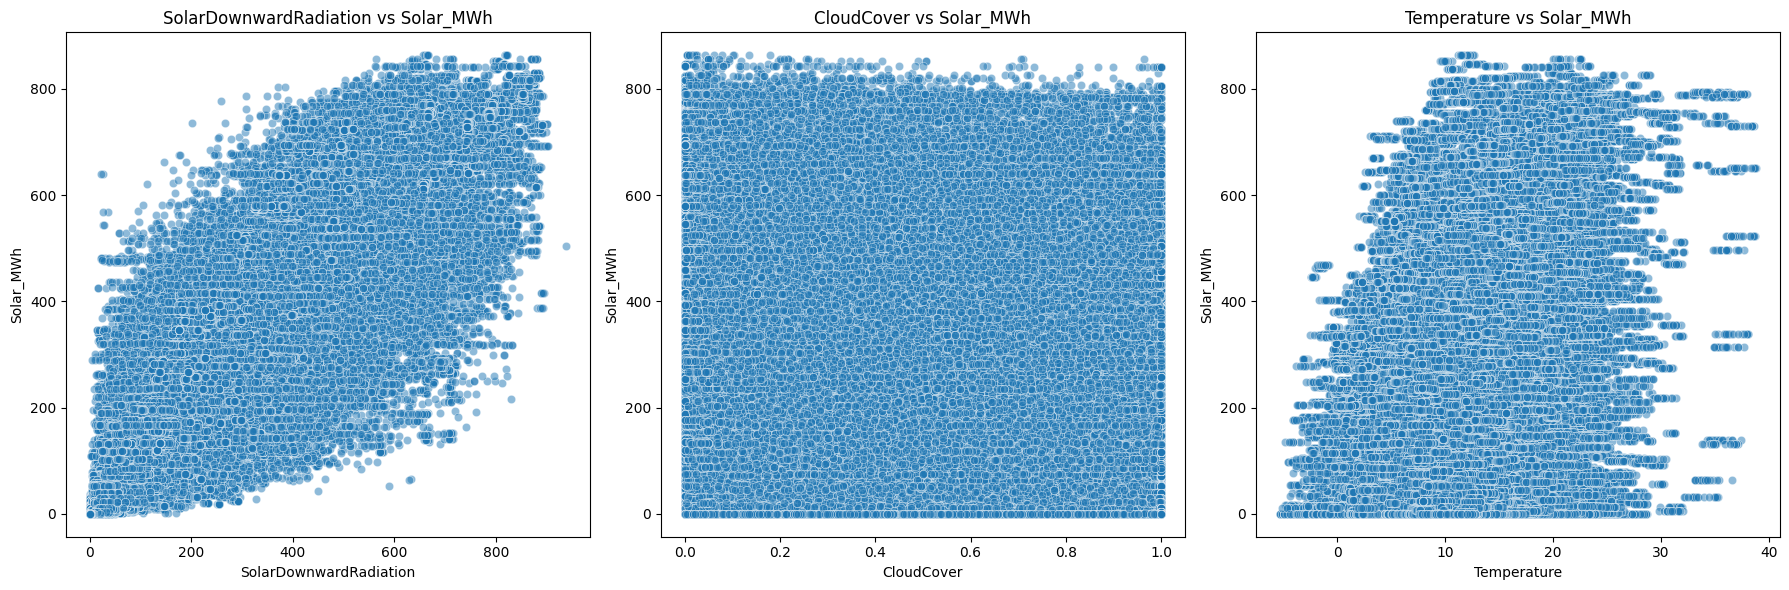

In [301]:
# 1.Plot erstellen
# Scatterplots für jede Wettervariable vs. Solar_MWh
weather_attributes = ["SolarDownwardRadiation", "CloudCover", "Temperature"]

plt.figure(figsize=(18, 6))
for i, attr in enumerate(weather_attributes):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=df_merged, x=attr, y="Solar_MWh", alpha=0.5)
    plt.title(f"{attr} vs Solar_MWh")
    plt.xlabel(attr)
    plt.ylabel("Solar_MWh")
plt.tight_layout()
plt.show()

In [229]:
# 2. Erkennung von Zusammenhängen
# Korrelationen zwischen Wetterattributen und Solar_MWh berechnen
correlations = df_merged[weather_attributes + ["Solar_MWh"]].corr()["Solar_MWh"].sort_values(ascending=False)
print("Korrelationen mit Solar_MWh:")
print(correlations)

Korrelationen mit Solar_MWh:
Solar_MWh                 1.000000
SolarDownwardRadiation    0.919344
Temperature               0.424393
CloudCover               -0.090518
Name: Solar_MWh, dtype: float64


Die Wolkenbedeckung weißt auf einen schwachen Zusammenhang zur Stromerzeugung, während die Sonneneinstrahlung wichtiger ist.

# Aufgabe 3 Vorverarbeitung

#### Behandlung von Ausreißern

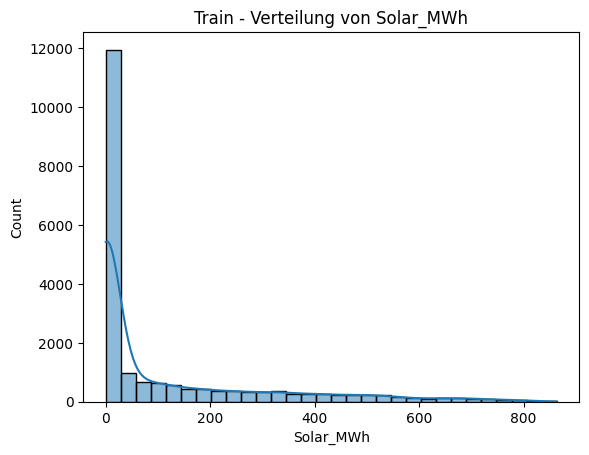

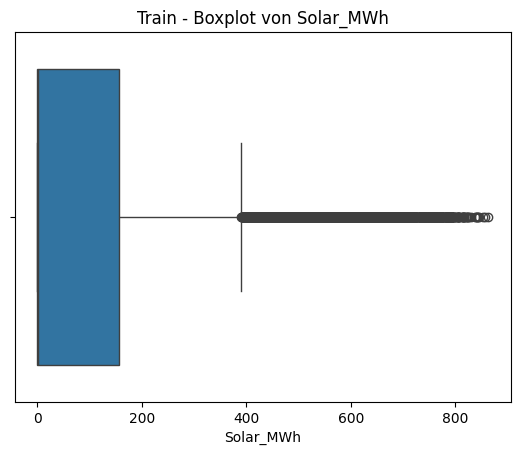

In [184]:
# Verteilung von Solar_MWh
sns.histplot(df_train["Solar_MWh"], kde=True, bins=30)
plt.title("Train - Verteilung von Solar_MWh")
plt.show()

# Boxplot zur Erkennung von Ausreißern
sns.boxplot(x=df_train["Solar_MWh"])
plt.title("Train - Boxplot von Solar_MWh")
plt.show()

**Interpretation**: Es wäre für mich eine logische Entscheidung die Ausreißer 0 mitzunehmen ins Modell, weil diese möglicherweise echte Werte sind. Das liegt daran, das Nachts keine Stromproduktion stattfindet, sowie im Winter die Nacht länger andauert. <br>
Zusätzlich ist es tagsüber deutlich inkonsistenter, da verschiedene Feature (Sonnenstrahlung, Wolkenbedeckung, Temperatur) Einfluss auf die die Stromproduktion nehmen.

Zusammengefasst entscheide ich mich die Ausreißer nicht rauszunehmen

#### Vorverarbeitung der Daten

In [317]:
df_merged

,Solar_capacity_mwp,Solar_MWh,SolarDownwardRadiation,CloudCover,Temperature,Weather Model,valid_datetime
0,2130.510089,0.0,-0.008356,0.327759,12.216522,DWD ICON,2020-09-21 00:00:00+00:00
1,2130.510089,0.0,0.000000,0.002000,12.240011,NCEP GFS,2020-09-21 00:00:00+00:00
2,2130.510089,0.0,0.008838,0.436067,12.015985,DWD ICON,2020-09-21 01:00:00+00:00
3,2130.510089,0.0,0.000000,0.003000,12.032483,NCEP GFS,2020-09-21 01:00:00+00:00
4,2130.510089,0.0,0.015384,0.468752,11.813635,DWD ICON,2020-09-21 02:00:00+00:00
...,...,...,...,...,...,...,...
347737,2237.476835,0.0,0.000000,1.000000,11.437307,NCEP GFS,2022-12-31 23:00:00+00:00
347738,2237.476835,0.0,0.000000,0.999300,12.259976,NCEP GFS,2022-12-31 23:00:00+00:00
347739,2237.476835,0.0,0.000000,0.985850,12.321409,NCEP GFS,2022-12-31 23:00:00+00:00
347740,2237.476835,0.0,0.000000,1.000000,12.463732,NCEP GFS,2022-12-31 23:00:00+00:00


In [315]:
df_merged = df_merged.drop(columns=["dtm", "ref_datetime_x", "valid_time", "ref_datetime_y"])

In [316]:
y = df_train.pop("Solar_MWh")
# Split in Trainings- und Testset
X_train, X_test, y_train, y_test = train_test_split(df_merged, y, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [347742, 19968]

In [ ]:
vorverarbeitung = ColumnTransformer([
    ("One Hot Encoding", OneHotEncoder(handle_unknown="ignore"),["Weather Model"]),
    ("Skalieren", StandardScaler(), ["Solar_capacity_mwp", "SolarDownwardRadiation", "CloudCover", "Temperature"]),
    ("Entfernen von Spalten", "drop", [])
], remainder="passthrough")

In [303]:
vorverarbeitung

ColumnTransformer(remainder='passthrough',
                  transformers=[('One Hot Encoding',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Weather Model']),
                                ('Skalieren', StandardScaler(),
                                 ['Solar_capacity_mwp',
                                  'SolarDownwardRadiation', 'CloudCover',
                                  'Temperature'])])

In [37]:
df_merged

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh,date,hour,is_weekend,month,day_of_year,season,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model,valid_datetime
0,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,0,False,9,265,4,24,-0.624898,-0.912255,0.289505,DWD ICON,2020-09-21 00:00:00+00:00
1,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,0,False,9,265,4,24,-0.624851,-1.872801,0.293458,NCEP GFS,2020-09-21 00:00:00+00:00
2,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,1,False,9,265,4,25,-0.624802,-0.592892,0.255763,DWD ICON,2020-09-21 01:00:00+00:00
3,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,1,False,9,265,4,25,-0.624851,-1.869853,0.258539,NCEP GFS,2020-09-21 01:00:00+00:00
4,2020-09-21 02:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,2,False,9,265,4,26,-0.624765,-0.496516,0.221716,DWD ICON,2020-09-21 02:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39555,2022-12-31 21:00:00+00:00,2022-12-30 18:00:00+00:00,1.062759,0.0,2022-12-31,21,True,12,365,1,27,-0.624851,1.069944,0.318090,NCEP GFS,2022-12-31 21:00:00+00:00
39556,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,1.062759,0.0,2022-12-31,22,True,12,365,1,28,-0.624886,1.069103,0.187818,DWD ICON,2022-12-31 22:00:00+00:00
39557,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,1.062759,0.0,2022-12-31,22,True,12,365,1,28,-0.624851,1.069944,0.342720,NCEP GFS,2022-12-31 22:00:00+00:00
39558,2022-12-31 23:00:00+00:00,2022-12-30 18:00:00+00:00,1.424270,0.0,2022-12-31,23,True,12,365,1,29,-0.624839,1.069944,0.108587,DWD ICON,2022-12-31 23:00:00+00:00


# Aufgabe 4 Generierung von neuen Features

## Vor dem Merge (nur aus df_train)

### Zeitbasierte Features

In [ ]:
# Tageszeit
df_train["hour"] = df_train["dtm"].dt.hour
# Monat oder Saison
df_train["month"] = df_train["dtm"].dt.month
df_train["season"] = df_train["month"].apply(lambda x: (x % 12 + 3) // 3)

C:\Users\QMoWo\AppData\Local\Temp\ipykernel_25884\1887285447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["hour"] = df_train["dtm"].dt.hour
C:\Users\QMoWo\AppData\Local\Temp\ipykernel_25884\1887285447.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_weekend"] = df_train["dtm"].dt.weekday >= 5
C:\Users\QMoWo\AppData\Local\Temp\ipykernel_25884\1887285447.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

### Lag-Features

In [132]:
df_train["lag_1"] = df_train["Solar_MWh"].shift(1)
df_train["lag_24"] = df_train["Solar_MWh"].shift(24)

C:\Users\QMoWo\AppData\Local\Temp\ipykernel_9292\4186051423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["lag_1"] = df_train["Solar_MWh"].shift(1)
C:\Users\QMoWo\AppData\Local\Temp\ipykernel_9292\4186051423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["lag_24"] = df_train["Solar_MWh"].shift(24)


### Rolling Features (Gleitender Durchschnitt):

In [133]:
df_train["rolling_mean_24"] = df_train["Solar_MWh"].rolling(window=24).mean()

C:\Users\QMoWo\AppData\Local\Temp\ipykernel_9292\1805592981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["rolling_mean_24"] = df_train["Solar_MWh"].rolling(window=24).mean()


## Nach dem Merge

### Interaktion von Wetter und Zeit
- temp_radiation_interaction: Produkt von Temperatur und Sonneneinstrahlung
- cloud_hour_interaction: Produkt von CloudCover und Stunde des Tages

In [161]:
df_merged["temp_radiation_interaction"] = (
    df_merged["Temperature"] * df_merged["SolarDownwardRadiation"]
)
df_merged["cloud_hour_interaction"] = (
    df_merged["CloudCover"] * df_merged["hour"]
)

### Relative Merkmale
Verhältnis von erzeugtem Strom zur verfügbaren Kapazität

In [162]:
df_merged["solar_efficiency"] = df_merged["Solar_MWh"] / df_merged["Solar_capacity_mwp"]

### Transformation von Wetterattributen:
- scaled_temperature: Skaliere Temperatur auf den Bereich [0, 1].
- adjusted_radiation: Negative Werte auf 0 setzen (falls noch nicht gemacht).

In [163]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_merged["scaled_temperature"] = scaler.fit_transform(
    df_merged[["Temperature"]]
)
df_merged["adjusted_radiation"] = df_merged["SolarDownwardRadiation"].clip(lower=0)

In [38]:
df_merged

,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh,date,hour,is_weekend,month,day_of_year,season,valid_time,SolarDownwardRadiation,CloudCover,Temperature,Weather Model,valid_datetime
0,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,0,False,9,265,4,24,-0.624898,-0.912255,0.289505,DWD ICON,2020-09-21 00:00:00+00:00
1,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,0,False,9,265,4,24,-0.624851,-1.872801,0.293458,NCEP GFS,2020-09-21 00:00:00+00:00
2,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,1,False,9,265,4,25,-0.624802,-0.592892,0.255763,DWD ICON,2020-09-21 01:00:00+00:00
3,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,1,False,9,265,4,25,-0.624851,-1.869853,0.258539,NCEP GFS,2020-09-21 01:00:00+00:00
4,2020-09-21 02:00:00+00:00,2020-09-20 00:00:00+00:00,-0.135082,0.0,2020-09-21,2,False,9,265,4,26,-0.624765,-0.496516,0.221716,DWD ICON,2020-09-21 02:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39555,2022-12-31 21:00:00+00:00,2022-12-30 18:00:00+00:00,1.062759,0.0,2022-12-31,21,True,12,365,1,27,-0.624851,1.069944,0.318090,NCEP GFS,2022-12-31 21:00:00+00:00
39556,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,1.062759,0.0,2022-12-31,22,True,12,365,1,28,-0.624886,1.069103,0.187818,DWD ICON,2022-12-31 22:00:00+00:00
39557,2022-12-31 22:00:00+00:00,2022-12-30 18:00:00+00:00,1.062759,0.0,2022-12-31,22,True,12,365,1,28,-0.624851,1.069944,0.342720,NCEP GFS,2022-12-31 22:00:00+00:00
39558,2022-12-31 23:00:00+00:00,2022-12-30 18:00:00+00:00,1.424270,0.0,2022-12-31,23,True,12,365,1,29,-0.624839,1.069944,0.108587,DWD ICON,2022-12-31 23:00:00+00:00


# Aufgabe 5 Modell trainieren

### Datenaufteilung

In [ ]:


feature_columns = [
    "SolarDownwardRadiation"#, "CloudCover", "Temperature"#, "hour", "month", "season"
]
target_column = "Solar_MWh"

X = df_merged[feature_columns]
y = df_merged[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tr

### Baseline-Modell

In [192]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)
print("Mean Absolute Error (Baseline):", root_mean_squared_error(y_test, y_pred))

Mean Absolute Error (Baseline): 72.27053257990018


### Optimierung von Ridge und Lasso

In [193]:
# Hyperparameter für Ridge und Lasso
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = GridSearchCV(Ridge(), param_grid, cv=5)
ridge.fit(X_train, y_train)

print("Best alpha (Ridge):", ridge.best_params_["alpha"])
print("Best RMSE (Ridge):", -ridge.best_score_)

# Lasso Regression
lasso = GridSearchCV(Lasso(max_iter=10000), param_grid, scoring="neg_root_mean_squared_error", cv=5)
lasso.fit(X_train, y_train)
print("Best alpha (Lasso):", lasso.best_params_["alpha"])
print("Best RMSE (Lasso):", -lasso.best_score_)

Best alpha (Ridge): 10
Best RMSE (Ridge): -0.8447710194142969
Best alpha (Lasso): 0.01
Best RMSE (Lasso): 72.49002552687753


### Modell 2: Entscheidungsbaum

In [194]:
# Hyperparameter für den Entscheidungsbaum
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

tree = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5)
tree.fit(X_train, y_train)
print("Best params (Decision Tree):", tree.best_params_)
print("Best RMSE (Decision Tree):", -tree.best_score_)

Best params (Decision Tree): {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best RMSE (Decision Tree): -0.8514343011844046


c:\Users\QMoWo\anaconda3\envs\dscb_duac1011\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### Modell 3: Ensemble-Modell (Random Forest)

In [ ]:
# Hyperparameter für Random Forest
param_grid = {
    'n_estimators': [15, 20, 25],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

forest = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
forest.fit(X_train, y_train)
print("Best params (Random Forest):", forest.best_params_)
print("Best RMSE (Random Forest):", -forest.best_score_)

Best params (Random Forest): {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}
Best RMSE (Random Forest): -0.895582824282301


### Wichtigste Features bestimmen

In [ ]:
# Feature-Wichtigkeiten für Ridge
ridge_coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": ridge.best_estimator_.coef_
}).sort_values(by="Importance", ascending=False)
print("Ridge Feature Importance:\n", ridge_coefficients)

# Feature-Wichtigkeiten für Random Forest
forest_importance = pd.DataFrame({
    "Feature": X_train.columns,
    #"Importance": forest.best_estimator_.feature_importances_
})#.sort_values(by="Importance", ascending=False)
print("Random Forest Feature Importance:\n", forest_importance)

Ridge Feature Importance:
                   Feature  Importance
1  SolarDownwardRadiation  173.190958
2              CloudCover    8.130598
0      Solar_capacity_mwp    3.081468
3             Temperature   -2.852932
Random Forest Feature Importance:
                   Feature  Importance
1  SolarDownwardRadiation    0.940996
0      Solar_capacity_mwp    0.029376
2              CloudCover    0.016166
3             Temperature    0.013462
